# Tutorial: Crystallization of Silicon

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

## 1. Plot COLVAR file

The COLVAR files contains most of the interesting output of the simulation. Let's have a look at the first few lines.

In [3]:
N=5
myfile=open("metad-1350K/COLVAR")
for x in range(N):
    print(next(myfile))

#! FIELDS time es.mean es.morethan metad.bias metad.rbias metad.rct

 0.000000 0.873185 209.922131 0.000000 0.000000 0.000000

 1.000000 0.860031 207.586632 15.184318 3.799497 35.007395

 2.000000 0.834867 203.065842 6.576416 -56.082132 64.844093

 3.000000 0.875239 209.480559 87.933274 5.155410 101.310691



As the first line points out, the columns correspond to the time (in ps), the mean of the kernels, the number of kernels that are above the threshold ~0.5, the metadynamics bias, the bias for reweighting, and the c(t)

Let's plot some of this quantities.

In [111]:
COLVAR=np.genfromtxt("metad-1350K/COLVAR")

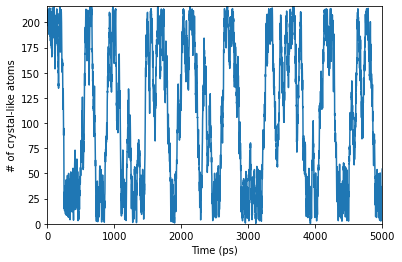

In [112]:
plt.plot(COLVAR[:,0],COLVAR[:,2])
plt.xlabel("Time (ps)")
plt.ylabel("# of crystal-like atoms")
plt.xlim([0,5000])
plt.ylim([0,216])
plt.show()

The plot above shows the CV as a function of time. We see that the system is going reversibly from the liquid (CV ~ 0) to the solid (CV ~ 216).

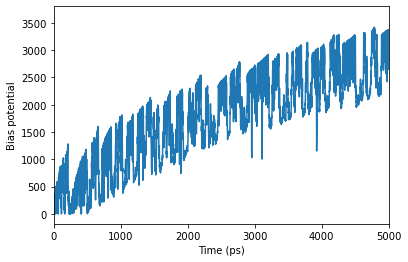

In [113]:
plt.plot(COLVAR[:,0],COLVAR[:,3])
plt.xlabel("Time (ps)")
plt.ylabel("Bias potential")
plt.xlim([0,5000])
plt.show()

The plot above shows the evolution of the bias potential. We see that on average it increases over time although the pace at which it grows decreases. This is a chracteristic of well tempered metadynamics: the bias potential changes more and more slowly as the simulation progresses. However, it will never stop growing and thus the bias potential will only be stationary in the infinite time limit.

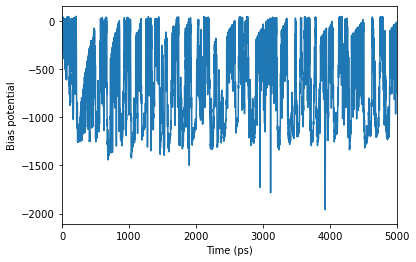

In [120]:
plt.plot(COLVAR[:,0],COLVAR[:,4])
plt.xlabel("Time (ps)")
plt.ylabel("Bias potential")
plt.xlim([0,5000])
plt.show()

The plot above shows the evolution of the bias potential for reweighting. At variance with the actual bias potential, the bias potential for reweghting does not grow (on average) during the simulation. It is thus closer to a static potential, for which the reweighting formula applies.

## 2. Plot FES

Now, let's plot the FES that should be stored in the fes.dat file, if you first run the command ```plumed sum_hills --hills HILLS```.

In [48]:
fes=np.genfromtxt("metad-1350K/fes.dat")

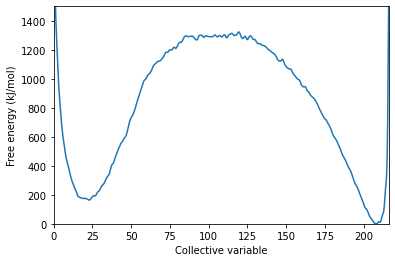

In [49]:
plt.plot(fes[:,0],fes[:,1]-np.amin(fes[:,1]))
plt.xlabel("Collective variable")
plt.ylabel("Free energy (kJ/mol)")
plt.xlim([0,216])
plt.ylim([0,1500])
plt.show()

Here you see that at 1350 K the solid (CV$\approx$200) is more stable than the liquid (CV$\approx$0) - because it has a lower free energy

## 3. Convergence

In order to asses convergence we can also calculate the FES as a function of simulation time. Let's calculate it every 250 ps with the command ```plumed sum_hills --hills HILLS --stride=250```

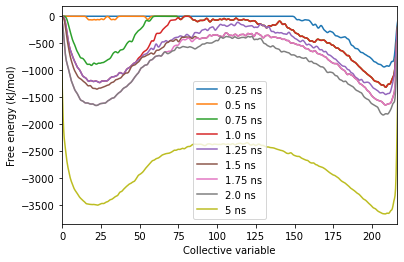

In [123]:
for i in range(8): # Only first eight files
    fes=np.genfromtxt("metad-1350K/fes_" + str(i) + ".dat")
    plt.plot(fes[:,0],fes[:,1],label=str((i+1)*0.25) + " ns")
fes=np.genfromtxt("metad-1350K/Results/fes.dat")
plt.plot(fes[:,0],fes[:,1],label="5 ns")
plt.xlabel("Collective variable")
plt.ylabel("Free energy (kJ/mol)")
plt.xlim([0,216])
plt.legend()
#plt.ylim([0,1500])
plt.show()

The figure above shows that during the first ns the shape of the FES changes substantially. After this simulation time the overall shape does not change substantially and only fine features are improved.

## 4. Reweighting

In [124]:
# This function calculates the FES using reweighting
def calculate_fes(cv,bias,temperature):
    kT=0.008314462618*temperature
    beta=1/(kT)
    logweights = beta*bias
    logweights -= np.amax(logweights)
    hist, bin_edges = np.histogram(cv,weights=np.exp(logweights),range=(0,216),bins=108)
    bin_centers=(bin_edges[:-1]+bin_edges[1:])/2
    fes = -kT*np.log(hist)
    fes -= np.amin(fes)
    return bin_centers, fes

The free energy can be calculated from the unbiased distribution of the CV $P(s)$ using:

$ F(s) = -k_B T \ln \left( P(s) \right)$

However, we don't have direct access to $P(s)$ and we must calculate it from the biased simulation using the formula,

$ P(s) = \langle \delta \left(s-s(\mathbf{R})\right ) \rangle = \frac{\langle \delta \left(s-s(\mathbf{R})\right ) e^{\beta V} \rangle_B}{\langle e^{\beta V} \rangle_B}$

where $\langle \cdot \rangle$ are unbiased averages and $\langle \cdot \rangle_B$ are biased averages. $\beta$ is the inverse temperature, $\mathbf{R}$ are the atomic coordinates, and $V$ is the bias potential.

| IN SHORT: $P(s)$ is a weighted histogram with weights $e^{\beta V}$ |
| --- |

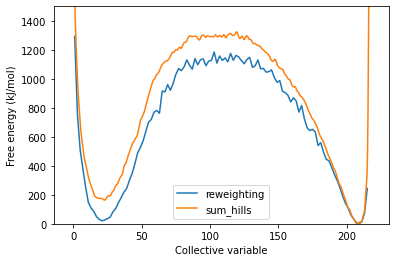

In [132]:
COLVAR=np.genfromtxt("metad-1350K/COLVAR")
Nignore=1000 # Discard first 1 ns
COLVAR=COLVAR[Nignore:,:]
cv=COLVAR[:,2]
bias=COLVAR[:,4]
temperature=1350
# From reweighting
bin_centers,fes = calculate_fes(cv,bias,temperature)
plt.plot(bin_centers,fes,label='reweighting')
# From sum_hills
fes=np.genfromtxt("metad-1350K/Results/fes.dat")
plt.plot(fes[:,0],fes[:,1]-np.amin(fes[:,1]),label='sum_hills')

plt.legend()
plt.xlabel("Collective variable")
plt.ylabel("Free energy (kJ/mol)")

plt.ylim([0,1500])
plt.show()

How do the estimates from reweighting and sum_hills compare?

Remember that in well-tempered metadynamics the effective free energy $ \tilde F(s)$ when the bias is converged is:

$ \tilde F(s) = F(s) / \gamma$

where $F(s)$ is the (unbiased) free energy and $\gamma$ is the bias factor.

The effective free energy can be calculated from the biased distribution of the CV $P_B(s)$ using:

$ \tilde F(s) = -k_B T \ln \left( P_B(s) \right)$

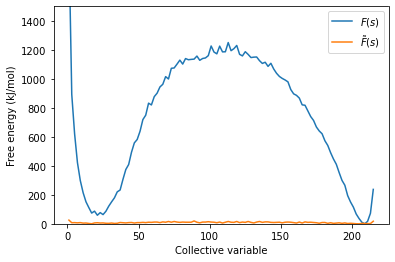

In [137]:
COLVAR=np.genfromtxt("metad-1350K/COLVAR")
Nignore=4000 # Discard first 1 ns
COLVAR=COLVAR[Nignore:,:]
cv=COLVAR[:,2]
bias=COLVAR[:,4]
temperature=1350
bias_factor=150

bin_centers,fes = calculate_fes(cv,bias,temperature)
plt.plot(bin_centers,fes,label=r'$F(s)$')

bin_centers,fes = calculate_fes(cv,np.ones(bias.shape[0]),temperature)
plt.plot(bin_centers,fes,label=r'$\tilde F(s)$')

plt.legend()
plt.xlabel("Collective variable")
plt.ylabel("Free energy (kJ/mol)")

plt.ylim([0,1500])
plt.show()

At this scale, the effective FES is almost flat. The barrier has gone from 150 $k_B T$ to around 1 $k_B T$.

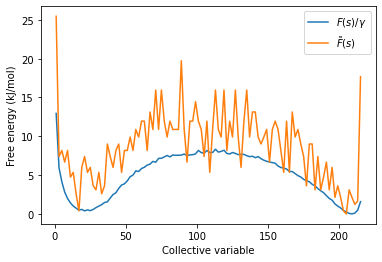

In [135]:
COLVAR=np.genfromtxt("metad-1350K/COLVAR")
Nignore=4000 # Discard first 1 ns
COLVAR=COLVAR[Nignore:,:]
cv=COLVAR[:,2]
bias=COLVAR[:,4]
temperature=1350
bias_factor=150

bin_centers,fes = calculate_fes(cv,bias,temperature)
plt.plot(bin_centers,fes/bias_factor,label=r'$F(s)/\gamma$')

bin_centers,fes = calculate_fes(cv,np.ones(bias.shape[0]),temperature)
plt.plot(bin_centers,fes,label=r'$\tilde F(s)$')

plt.legend()
plt.xlabel("Collective variable")
plt.ylabel("Free energy (kJ/mol)")

#plt.ylim([0,1500])
plt.show()

The effective FES is similar when calculated from $P_B(s)$ and from $F(s)/\gamma$, as should be in the metadynamics algorithm.

## 5. Calculation of free energy differences

Let's analyze three methods to compute free energy differences

In [155]:
COLVAR=np.genfromtxt("metad-1350K/COLVAR")
Nignore=1000 # Discard first 1 ns
COLVAR=COLVAR[Nignore:,:]
cv=COLVAR[:,2]
bias=COLVAR[:,4]
temperature=1350
kT=0.008314462618*temperature
beta=1/(kT)
bias_factor=150
bin_centers,fes = calculate_fes(cv,bias,temperature)
N=fes.shape[0]

### First method
$\Delta F = F(s_A) - F(s_B)$ where $s_A$ is the position of the free energy minimum in basin A and $s_B$ is the position of the free energy minimum in basin B.

This is an approximation, but a relatively good one if the difference in free energy is large and the barrier is large with respect to $k_B T$

In [156]:
freeEnergyLiquid=np.amin(fes[:int(N/2)])
freeEnergySolid=np.amin(fes[int(N/2):])
deltaFreeEnergy=freeEnergySolid-freeEnergyLiquid
print("The difference in free energy between the solid and the liquid is: " + "{:.{}f}".format(deltaFreeEnergy,2) + " kJ/mol or " + "{:.{}f}".format(deltaFreeEnergy/kT,2) + " kT.")
print("Therefore at this temperature the solid is more stable than the liquid.")

20.61843645376092 0.0
The difference in free energy between the solid and the liquid is: -20.62 kJ/mol or -1.84 kT.
Therefore at this temperature the solid is more stable than the liquid.


### Second method

A rigurous definition for the free energy difference is:

$\Delta F = -k_B T \ln \left (\frac{\int\limits_{s^*}^N ds e^{-\beta F(s)}}{\int\limits_0^{s^*} ds e^{-\beta F(s)}} \right)$

where $s*$ is a watershed between the liquid and the solid.

In [157]:
integral1=np.trapz(np.exp(-beta*fes[int(N/2):])) # solid
integral2=np.trapz(np.exp(-beta*fes[:int(N/2)])) # liquid
# deltaX cancels out in the quotient integral1/integral2
deltaFreeEnergy=-kT*np.log(integral1/integral2)
print("The difference in free energy between the solid and the liquid is: " + "{:.{}f}".format(deltaFreeEnergy,2) + " kJ/mol or " + "{:.{}f}".format(deltaFreeEnergy/kT,2) + " kT.")
print("Therefore at this temperature the solid is more stable than the liquid.")

-6.4294664404603035 10.418154160359379
The difference in free energy between the solid and the liquid is: -16.85 kJ/mol or -1.50 kT.
Therefore at this temperature the solid is more stable than the liquid.


### Third method

An equivalent approach to the integration above, that does not require calculating $F(s)$ is:

$\Delta F = -k_B T \ln \left ( \frac{\langle H(s-s^*) \rangle}{\langle 1- H(s-s^*) \rangle} \right ) $

where $\langle \cdot \rangle$ is an unbiased average, which can be calculated with reweighting, and $H(s-s*)$ is a unit step function at the watershed $s^*$

In [158]:
logweights = beta*bias
logweights -= np.amax(logweights)
CVmax=216
halfCVmax=CVmax/2
probSolid=np.sum(np.exp(logweights[cv>halfCVmax])) # solid
probLiquid=np.sum(np.exp(logweights[cv<halfCVmax])) # liquid
deltaFreeEnergy=-kT*np.log(probSolid/probLiquid)
print("The difference in free energy between the solid and the liquid is: " + "{:.{}f}".format(deltaFreeEnergy,2) + " kJ/mol or " + "{:.{}f}".format(deltaFreeEnergy/kT,2) + " kT.")
print("Therefore at this temperature the solid is more stable than the liquid.")

-41.79376766204543 -24.94614706007786
The difference in free energy between the solid and the liquid is: -16.85 kJ/mol or -1.50 kT.
Therefore at this temperature the solid is more stable than the liquid.


## 6. Plot FES at different temperatures

Run simulations at other temperatures, for instance 1300 K, 1400 K, and 1450 K and compare results.

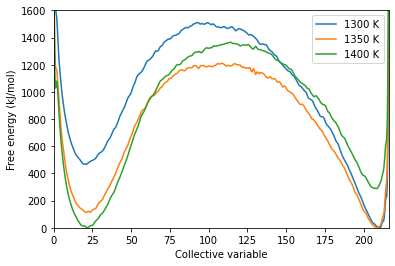

In [4]:
fes=np.genfromtxt("metad-1300K/fes.dat")
plt.plot(fes[:,0],fes[:,1]-np.amin(fes[:,1]),label="1300 K")

fes=np.genfromtxt("metad-1350K/fes.dat")
plt.plot(fes[:,0],fes[:,1]-np.amin(fes[:,1]),label="1350 K")

fes=np.genfromtxt("metad-1400K/fes.dat")
plt.plot(fes[:,0],fes[:,1]-np.amin(fes[:,1]),label="1400 K")

plt.legend()
plt.xlabel("Collective variable")
plt.ylabel("Free energy (kJ/mol)")
plt.xlim([0,216])
plt.ylim([0,1600])
plt.show()

## 7. Chemical potential differences at different temperatures

The chemical potential difference is defined as $\Delta\mu = \Delta F/ N$ with $N$ the number of atoms.

In [5]:
# This function calculates the difference in chemical potential using reweighting
def calculate_chemical_potential(cv,bias,temperature,watershed,N):
    kT=0.008314462618*temperature
    beta=1/(kT)
    logweights = beta*bias
    logweights -= np.amax(logweights)
    probSolid=np.sum(np.exp(logweights[cv>watershed])) # solid
    probLiquid=np.sum(np.exp(logweights[cv<watershed])) # liquid
    deltaFreeEnergy=-kT*np.log(probSolid/probLiquid)
    return deltaFreeEnergy/N

In [7]:
mu=[]
N=216 # Number of atoms
watershed=float(N/2)
temperatures=np.array([1300,1350,1400])
for temperature in temperatures:
    COLVAR=np.genfromtxt("metad-" + str(temperature) + "K/COLVAR")
    Nignore=1000 # Discard first 1 ns
    COLVAR=COLVAR[Nignore:,:]
    cv=COLVAR[:,2]
    bias=COLVAR[:,4]
    mu.append(calculate_chemical_potential(cv,bias,temperature,watershed,N))

Approximate melting temperature:  1360.8150858743027  K.


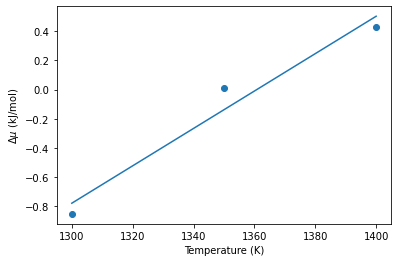

In [8]:
plt.scatter(temperatures,mu)

def linear(x,x0,b):
    return b*(x-x0)

popt, pcov = curve_fit(linear, temperatures,mu)

x=np.linspace(1300,1400,100)
plt.plot(x,linear(x,*popt))

plt.xlabel("Temperature (K)")
plt.ylabel(r"$\Delta\mu$ (kJ/mol)")

print("Approximate melting temperature: ",popt[0], " K.")
plt.show()

## 8. Errors

Estimating errors is an important part of these calculations that may not be covered here due to the short simulations which can be run during the tutorial. We recommend to gather estimates from all participants and calculate errors based on the independent calculations made by participants. You can find more information about the calculation of errors [here](https://www.plumed.org/doc-v2.8/user-doc/html/masterclass-21-2.html).